In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log2
from scipy.stats import fit, exponnorm, gaussian_kde
from IPython.display import Image

import configuration as config

/mnt/arkk/llm_detector/classifier


# Perplexity ratio score: Kullback–Leibler divergence

Plan here is to take our sampling distributions of perplexity ratio scores for human and synthetic text and use them to generate a function that takes a perplexity ratio score and converts it into a Kullback-Leibler score. See the figure below from the [Wikipedia article on KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

In [2]:
Image(url = 'https://raw.githubusercontent.com/gperdrizet/llm_detector/benchmarking/benchmarking/notebooks/images/KL-Gauss-Example.png')

Plan is as follows:
2. Plot and fit the distributions of perplexity ratio scores from human and synthetic text from the training data.
3. Calculate the Kullback-Leibler divergence between the fitted distributions.
4. Use a kernel density estimate of the Kullback-Leibler divergence to get it's probability density function.
5. Use the Kullback-Leibler divergence PDF to calculate a 'Kullback-Leibler score' from the perplexity ratio score for each text fragment in the training and testing datasets.

## TODO
1. Since KL divergence is not symmetrical, maybe we should include two features one for KL divergence between the human and synthetic score distributions in each direction...
2. Maybe try some of the other fits, e.g. gaussian rather than exponential gaussian.

In [3]:
input_file = config.FEATURE_ENGINEERING_CLASS_INSTANCE

with open(input_file, 'rb') as file:
    loaded_data = pickle.load(file)

<class 'pandas.core.frame.DataFrame'>
Index: 12716 entries, 0 to 12715
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (words)   12716 non-null  int64  
 1   Fragment length (tokens)  12716 non-null  int64  
 2   Dataset                   12716 non-null  object 
 3   Source                    12716 non-null  object 
 4   String                    12716 non-null  object 
 5   Perplexity                12716 non-null  float64
 6   Cross-perplexity          12716 non-null  float64
 7   Perplexity ratio score    12716 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 894.1+ KB


In [4]:
# Extract perplexity score ratios as lists
scores = training_data_df['Perplexity ratio score']
human_scores = training_data_df['Perplexity ratio score'][training_data_df['Source'] == 'human']
synthetic_scores = training_data_df['Perplexity ratio score'][training_data_df['Source'] == 'synthetic']

# Set up bins for the combined dataset
counts, bins = np.histogram(scores, bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and synthetic data
human_density, human_bins = np.histogram(human_scores, bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(synthetic_scores, bins = bins, density = True)

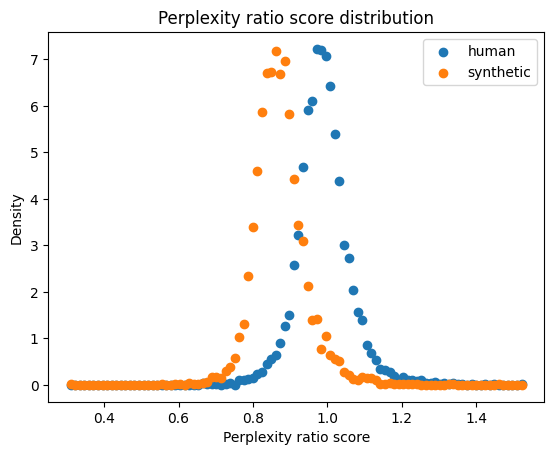

In [5]:
# Plot as scatter
plt.scatter(bin_centers, human_density, label = 'human')
plt.scatter(bin_centers, synthetic_density, label = 'synthetic')

plt.title('Perplexity ratio score distribution')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc = 'upper right')
plt.show()

Now, fit the individual distributions with an exponential Gaussian:

In [6]:
# Exponential Gaussian
bounds = [[0,10],[0.6,1.2],[0,10]]

human_exponnorm = fit(exponnorm, human_scores, bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(bin_centers)

synthetic_exponnorm = fit(exponnorm, synthetic_scores, bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(bin_centers)

/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1782: RuntimeWarning: overflow encountered in scalar divide
  invK = 1.0 / K


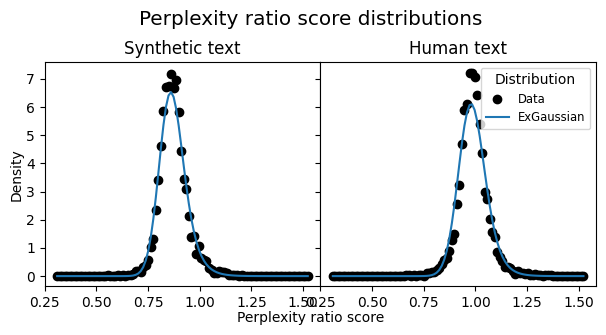

In [7]:
fig, axs = plt.subplots(
    1,
    2,
    figsize = (6, 3),
    sharex = 'col',
    sharey = 'row',
    tight_layout = True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(bin_centers, synthetic_density, color = 'black', label = 'Data')
axs[0].plot(bin_centers, synthetic_exponnorm_fit, label = 'ExGaussian')

axs[1].set_title('Human text')
axs[1].scatter(bin_centers, human_density, color = 'black', label = 'Data')
axs[1].plot(bin_centers, human_exponnorm_fit, label = 'ExGaussian')

axs[1].legend(
    title = 'Distribution',
    loc = 'upper right',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'Perplexity ratio score distributions', ha = 'center', fontsize = 'x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'Perplexity ratio score', ha = 'center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va = 'center', ha = 'center', rotation = 90)

plt.show()

Ok, looks good to me - let's take a closer look at the fits.

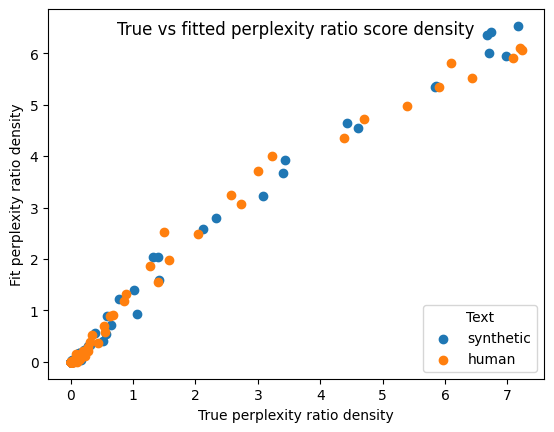

In [8]:
plt.title('True vs fitted perplexity ratio score density', y = 1.0, pad = -18)
plt.scatter(synthetic_density, synthetic_exponnorm_fit, label = 'synthetic')
plt.scatter(human_density, human_exponnorm_fit, label = 'human')
plt.legend(title = 'Text', loc = 'lower right')
plt.xlabel('True perplexity ratio density')
plt.ylabel('Fit perplexity ratio density')
plt.show()

OK, looks good enough to me - now let's take a look at the Kullback-Leibler divergence of the two fits.

In [9]:
def kl_divergence(p, q):
    '''Takes two lists, calculates KL divergence'''

    return [p[i] * log2(p[i]/q[i]) for i in range(len(p))]

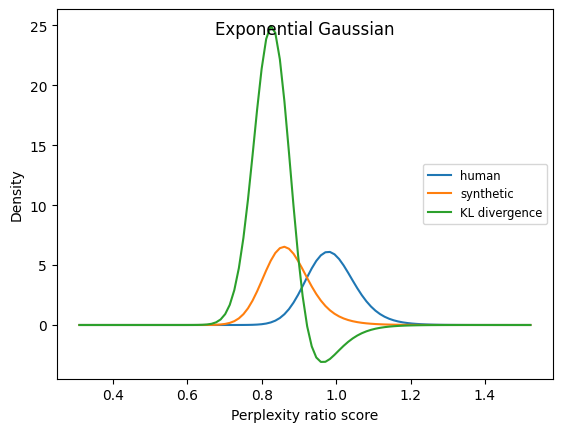

In [10]:
plt.title('Exponential Gaussian', y = 1.0, pad = -18)
plt.plot(bin_centers, human_exponnorm_fit, label = 'human')
plt.plot(bin_centers, synthetic_exponnorm_fit, label = 'synthetic')
plt.plot(bin_centers, kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit), label = 'KL divergence')
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc = 'center right', fontsize = 'small')
plt.show()

Now we need to use fitted perplexity ratio score distributions to calculate and add the KL score for each text fragment in the dataset.

In [11]:
# Get a kernel density estimate of the KL divergence so we can use the
# associated probability density function to convert perplexity ratio scores
# into KL scores

# Get a list of points covering the range of score values
x = np.arange(min(scores) - 0.25, max(scores) + 0.25, 0.001).tolist()
print(f'Will calculate {len(x)} fitted values')

# Do the exponential gaussian fits and get values for f(x)
bounds = [[0,10],[0.6,1.2],[0,10]]

human_exponnorm = fit(exponnorm, human_scores, bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(x)

synthetic_exponnorm = fit(exponnorm, synthetic_scores, bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(x)

# Calculate the KL divergence of the fitted values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)

print(f'\nHuman K: {human_exponnorm.params.K}')
print(f'Human loc: {human_exponnorm.params.loc}')
print(f'Human scale: {human_exponnorm.params.scale}')

print(f'\nSynthetic K: {synthetic_exponnorm.params.K}')
print(f'Synthetic loc: {synthetic_exponnorm.params.loc}')
print(f'Synthetic scale: {synthetic_exponnorm.params.scale}\n')

print(f'Have {len(kl)} KL divergence values')

Will calculate 1725 fitted values


/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)



Human K: 0.7608303756752076
Human loc: 0.9466326054099743
Human scale: 0.055055602356010196

Synthetic K: 0.8985269256411221
Synthetic loc: 0.8276551060320249
Synthetic scale: 0.04940611445758383

Have 1725 KL divergence values


Min KL count value 0
Max KL count value: 2809


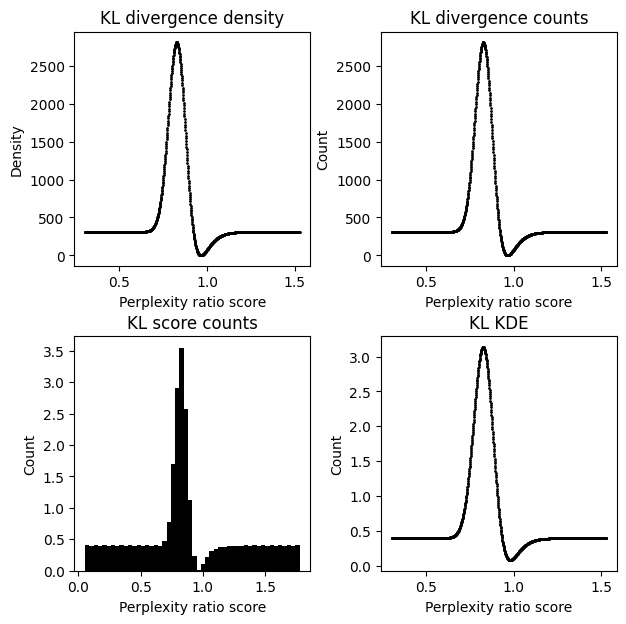

In [12]:
# Convert the kl 'density' values into integer 'count' values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)
kl = kl + abs(min(kl))
kl = kl * 100
kl_counts = [int(density) for density in kl]

print(f'Min KL count value {min(kl_counts)}')
print(f'Max KL count value: {max(kl_counts)}')

# Now, construct a list where each value of x appears a number of times
# equal to it's kl 'count'
kl_scores = []

for i in range(len(kl_counts)):
    kl_scores.extend([x[i]] * kl_counts[i])

# Finally, run a KDE on the reconstructed KL scores
kl_kde = gaussian_kde(kl_scores)

# And use it's PDF to get density for x after re-clipping x to the
# range of the original data
clipped_x = []
clipped_kl = []
clipped_kl_counts = []

for i, j in enumerate(x):
    if j > min(scores) and j < max(scores):
        clipped_x.append(j)
        clipped_kl.append(kl[i])
        clipped_kl_counts.append(kl_counts[i])

clipped_kl_kde_values = kl_kde.pdf(clipped_x)

fig, axs = plt.subplots(
    2,
    2,
    figsize = (7, 7),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

axs[0,0].set_title('KL divergence density')
axs[0,0].scatter(clipped_x, clipped_kl, color='black', s = 1)
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Density')

axs[0,1].set_title('KL divergence counts')
axs[0,1].scatter(clipped_x, clipped_kl_counts, color='black', s = 1)
axs[0,1].set_xlabel('Perplexity ratio score')
axs[0,1].set_ylabel('Count')

axs[1,0].set_title('KL score counts')
axs[1,0].hist(kl_scores, bins=50, color='black', density = True)
axs[1,0].set_xlabel('Perplexity ratio score')
axs[1,0].set_ylabel('Count')

axs[1,1].set_title('KL KDE')
axs[1,1].scatter(clipped_x, clipped_kl_kde_values, color='black', s = 1)
axs[1,1].set_xlabel('Perplexity ratio score')
axs[1,1].set_ylabel('Count')

plt.show()

OK, cool. Looks good. Now we can run the perplexity ratio score column from the Hans text fragment data through the KL KDE's PDF and add the result to the dataframe.

In [13]:
kl_scores = kl_kde.pdf(training_data_df['Perplexity ratio score'])
training_data_df['Perplexity ratio Kullback-Leibler score'] = kl_scores

training_data_df.info()
print()
training_data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 12716 entries, 0 to 12715
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (words)                  12716 non-null  int64  
 1   Fragment length (tokens)                 12716 non-null  int64  
 2   Dataset                                  12716 non-null  object 
 3   Source                                   12716 non-null  object 
 4   String                                   12716 non-null  object 
 5   Perplexity                               12716 non-null  float64
 6   Cross-perplexity                         12716 non-null  float64
 7   Perplexity ratio score                   12716 non-null  float64
 8   Perplexity ratio Kullback-Leibler score  12716 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 993.4+ KB



,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score
0,182,231,cc_news,human,a patrol shift due to the department being sho...,2.547,2.613281,0.974589,0.083768
1,32,43,cc_news,human,"athletes from Fairfield, Hillsboro and McClain...",3.443,3.337891,1.031597,0.203343
2,141,187,cnn,human,"could be habitable. If confirmed, it would sug...",2.664,2.703125,0.985549,0.084467
3,185,267,cc_news,human,agreement to develop branded products and open...,2.506,2.587891,0.968302,0.094647
4,129,159,cc_news,synthetic,"in 1975.\nEven more to the point, Britain has ...",2.275,2.714844,0.838129,3.053975


Re-plot just to be sure we got the result we expected

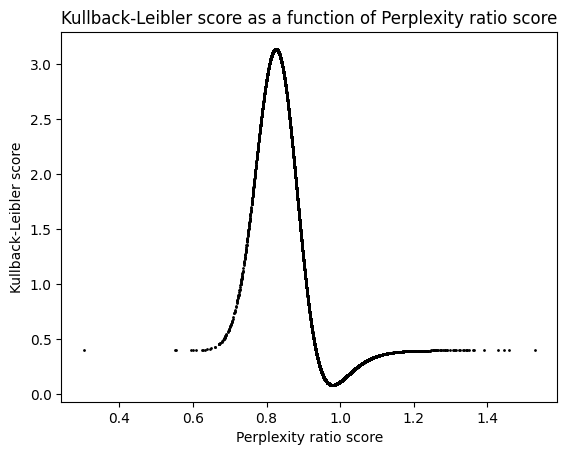

In [14]:
plt.title('Kullback-Leibler score as a function of Perplexity ratio score')
plt.scatter(training_data_df['Perplexity ratio score'], training_data_df['Perplexity ratio Kullback-Leibler score'], color='black', s = 1)
plt.xlabel('Perplexity ratio score')
plt.ylabel('Kullback-Leibler score')
plt.show()

Nailed it! Save for the next step.

In [15]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA_PR

with open(output_file, 'w') as file:
    file.write(training_data_df.to_json())

Now do the same thing with the test data, using the PDF derived from the training data

In [16]:
# Load the testing data
testing_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TESTING_DATA)

# Replace and remove string 'OOM' and 'NAN' values
testing_data_df.replace('NAN', np.nan, inplace = True)
testing_data_df.replace('OOM', np.nan, inplace = True)
testing_data_df.dropna(inplace = True)

# Fix some d-types
testing_data_df = testing_data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

testing_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3179 entries, 0 to 3178
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (words)   3179 non-null   int64  
 1   Fragment length (tokens)  3179 non-null   int64  
 2   Dataset                   3179 non-null   object 
 3   Source                    3179 non-null   object 
 4   String                    3179 non-null   object 
 5   Perplexity                3179 non-null   float64
 6   Cross-perplexity          3179 non-null   float64
 7   Perplexity ratio score    3179 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 223.5+ KB


In [17]:
kl_scores = kl_kde.pdf(testing_data_df['Perplexity ratio score'])
testing_data_df['Perplexity ratio Kullback-Leibler score'] = kl_scores

testing_data_df.info()
print()
testing_data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3179 entries, 0 to 3178
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (words)                  3179 non-null   int64  
 1   Fragment length (tokens)                 3179 non-null   int64  
 2   Dataset                                  3179 non-null   object 
 3   Source                                   3179 non-null   object 
 4   String                                   3179 non-null   object 
 5   Perplexity                               3179 non-null   float64
 6   Cross-perplexity                         3179 non-null   float64
 7   Perplexity ratio score                   3179 non-null   float64
 8   Perplexity ratio Kullback-Leibler score  3179 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 248.4+ KB



,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score,Perplexity ratio Kullback-Leibler score
0,114,165,cc_news,human,notify Amtrak conductors to hold the train for...,2.812,2.947266,0.954274,0.160029
1,374,492,cc_news,human,a heavenly choir to fill the room. He heard no...,3.068,2.902344,1.057201,0.271591
2,331,433,cc_news,synthetic,really being away from home and being around p...,2.252,2.564453,0.878142,1.986757
3,135,174,cc_news,human,It’s like the markets and the Bank of Canada a...,2.230,2.351562,0.948505,0.207380
4,276,390,cc_news,human,Albertina Nakale\nWINDHOEK – Sahrawi Arab Demo...,2.402,2.355469,1.019900,0.167786


Take a quick look before saving the testing data

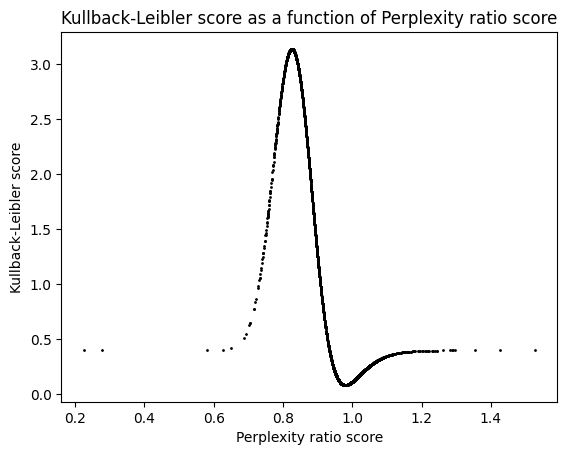

In [18]:
plt.title('Kullback-Leibler score as a function of Perplexity ratio score')
plt.scatter(testing_data_df['Perplexity ratio score'], testing_data_df['Perplexity ratio Kullback-Leibler score'], color = 'black', s = 1)
plt.xlabel('Perplexity ratio score')
plt.ylabel('Kullback-Leibler score')
plt.show()

In [19]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_TESTING_DATA_PR

with open(output_file, 'w') as file:
    file.write(testing_data_df.to_json())

Finally, save the Kullback–Leibler kernel density estimate for future use.

In [20]:
from pickle import dump

output_file = config.PERPLEXITY_RATIO_KL_KDE

with open(output_file, 'wb') as file:
    dump(kl_kde, file, protocol = 5)